In [1]:
import tenseal as ts
import os
import utils
import flwr as fl
import tensorflow as tf
from tensorflow import keras
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from time import time
from fractions import Fraction
from sklearn.metrics import confusion_matrix

In [2]:
# Load and compile Keras model
# model = keras.Sequential([
    #keras.layers.Flatten(input_shape=(28,28)),
    #keras.layers.Dense(128, activation='relu'),
    #keras.layers.Dense(256, activation='relu'),
    #keras.layers.Dense(10, activation='softmax')])
#model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])'''

In [3]:
# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

# Define the distribution
dist = [0, 10, 10, 10, 4000, 3000, 4000, 5000, 10, 4500]
#dist = [4000, 4000, 4000, 3000, 10, 10, 10, 10, 4000, 10]

In [4]:
# Slicing the MNIST original dataset to retain only part of the dataset.
#x_train = x_train[20000:,:,:]
#y_train = y_train[20000:]
#x_test = x_test[4000:,:,:]
#y_test  = y_test[4000:]

In [5]:
# Auxillary methods
def getDist(y):
    ax = sns.countplot(x = y)
    ax.set(title="Count of data classes")
    plt.show()

def getData(dist, x, y):
    dx = []
    dy = []
    counts = [0 for i in range(10)]
    for i in range(len(x)):
        if counts[y[i]]<dist[y[i]]:
            dx.append(x[i])
            dy.append(y[i])
            counts[y[i]] += 1
        
    return np.array(dx), np.array(dy)

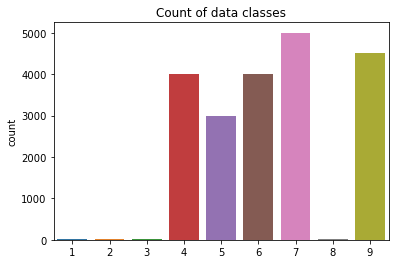

In [6]:
x_train, y_train = getData(dist, x_train, y_train)
getDist(y_train)

In [9]:
# Slicing the MNIST original dataset to retain only part of the dataset.
#x_train = x_train[20000:40596,:,:]
#y_train = y_train[20000:40596]
#x_test = x_test[4000:7139,:,:]
#y_test  = y_test[4000:7139]

In [10]:
# Length of the new dataset
print("x_train:", len(x_train))
print("y_train:", len(y_train))
print("x_test:", len(x_test))
print("y_test:", len(y_test))

x_train: 20540
y_train: 20540
x_test: 10000
y_test: 10000


In [5]:
# Retrieve the base model
new_model = tf.keras.models.load_model('./saved_model/base_model')
# Check its architecture.
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7840      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                100       
                                                                 
Total params: 7,940
Trainable params: 7,940
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Creating a multiclass confusion matrix before training.
predictions = new_model.predict(x_test)
confusion = confusion_matrix(y_test, np.argmax(predictions,axis=1))
confusion

313/313 [==============================] - 1s 2ms/step


array([[ 950,    0,    3,    2,    2,    6,   11,    1,    5,    0],
       [   0, 1110,    6,    4,    1,    1,    3,    0,   10,    0],
       [  12,    6,  902,   22,   14,    1,   15,   14,   44,    2],
       [   5,    1,   21,  902,    1,   32,    3,   14,   22,    9],
       [   1,    4,    5,    0,  918,    0,   12,    0,    7,   35],
       [  18,    2,    6,   56,   12,  718,    7,    7,   60,    6],
       [  22,    3,   12,    0,   16,   15,  881,    0,    9,    0],
       [   3,   23,   24,   10,    7,    0,    0,  924,    3,   34],
       [   6,   11,   12,   30,   16,   27,    9,   17,  835,   11],
       [  11,    5,    0,   15,   69,    4,    0,   24,   10,  871]],
      dtype=int64)

In [13]:
# Evaluate the base_model to see the loss and sparse_categorical_accuracy before training.
new_model.evaluate(x_test, y_test)

C:\Users\USER\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 [==============================] - 1s 2ms/step - loss: 0.3539 - sparse_categorical_accuracy: 0.9011


[0.3539418578147888, 0.9010999798774719]

In [14]:
# Compiling the model.
new_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [15]:
# Retraining the base_model to obtain the new weights.
new_model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/10
161/161 [==============================] - 2s 6ms/step - loss: 0.4332 - sparse_categorical_accuracy: 0.8518 - val_loss: 1.1297 - val_sparse_categorical_accuracy: 0.6697
Epoch 2/10
161/161 [==============================] - 1s 5ms/step - loss: 0.3536 - sparse_categorical_accuracy: 0.8793 - val_loss: 1.4815 - val_sparse_categorical_accuracy: 0.5940
Epoch 3/10
161/161 [==============================] - 1s 4ms/step - loss: 0.3167 - sparse_categorical_accuracy: 0.8928 - val_loss: 1.8132 - val_sparse_categorical_accuracy: 0.5368
Epoch 4/10
161/161 [==============================] - 1s 4ms/step - loss: 0.2935 - sparse_categorical_accuracy: 0.9011 - val_loss: 1.9683 - val_sparse_categorical_accuracy: 0.5181
Epoch 5/10
161/161 [==============================] - 1s 4ms/step - loss: 0.2776 - sparse_categorical_accuracy: 0.9037 - val_loss: 2.3294 - val_sparse_categorical_accuracy: 0.4988
Epoch 6/10
161/161 [==============================] - 1s 4ms/step - loss: 0.2723 - sparse_categorica

In [16]:
# Evaluate the base_model to see the loss and sparse_categorical_accuracy after training.
new_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 2.8403 - sparse_categorical_accuracy: 0.4682


[2.8402512073516846, 0.4681999981403351]

In [2]:
#Extracting weights & bias.
# Checking which layers have weights & bias.
#for layer in new_model.layers:
#    print(layer.name, len(layer.weights))

In [3]:
def client_gentry_encrypt (K, r, p, q):
    # Extract the weights.
    client_weights = new_model.layers[1].get_weights()
    # Mask the weights
    res_A = [(x + K) for x in client_weights]
    
    # Splitting the weights array into 2 arrays 'arr0' and 'arr1'
    # This is because protobuf has a hardlimit of 2GB, hence, we split the weights into 2 arrays.
    arr = np.array(res_A)
    arr0, arr1 = np.dsplit(arr, 2)
    
    #encrypt mask weights A
    encrypt_A = [(x + (2*r) + (q*p)) for x in res_A]
    # stored the encrpyted weights in dict. 
    client2_query_gentry = { "data1" : encrypt_A,}
    
    # Store the encrypyted weights 
    enc_2 = pickle.dumps(client2_query_gentry)
    with open("client2_enc_gentry", "wb") as file:
        file.write(enc_2)
    
    
    return arr0, arr1

In [6]:
t_start = time()
arr0, arr1 = client_gentry_encrypt(-500, 3, 29, 22)
t_end = time()
print("c2p gentry time: {} ms".format((t_end - t_start) * 1000))

c2p gentry time: 19.17099952697754 ms


### Client Encryption

In [7]:
def encrypt_weights():
    #obtain the context from the file 
    key_query_file = open('key_query', "rb")
    context_key = pickle.load(key_query_file)
    key_query_file.close()

    # Recreate the key.
    context = ts.context_from(context_key["context"])
    
    # perform Encryption on the weights for the first group arr0
    t_start = time()
    enc_v1 = ts.ckks_tensor(context, arr0)
    enc_v1_serialised = enc_v1.serialize()
    # Perform Encryption on the weights for the second group arr1
    enc_v2 = ts.ckks_tensor(context, arr1)
    enc_v2_serialised = enc_v2.serialize()
    t_end = time()
    print("weight encryption time for client: {} ms".format((t_end - t_start) * 1000))
    
    # Store the encrypted weights in a dict
    client2_query = {"data1" : enc_v1_serialised, "data2" : enc_v2_serialised}
    
    # Save the encrypted weights in a pickle file
    input_dictionary = (client2_query)
    file = open('client2_enc', 'wb')
    pickle.dump(input_dictionary, file)
    file.close()
    
    return context
context = encrypt_weights()

weight encryption time for client: 351942.85440444946 ms


## Load the updated model

In [7]:
#In this section, we uload the updated model which have the averaged weights from the server.
updated_model = tf.keras.models.load_model('saved_model/updated_model')

In [8]:
# Check its architecture
updated_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7840      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                100       
                                                                 
Total params: 7,940
Trainable params: 7,940
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Creating a multiclass confusion matrix before training.
predictions = updated_model.predict(x_test)
confusion = confusion_matrix(y_test, np.argmax(predictions,axis=1))
confusion

313/313 [==============================] - 3s 6ms/step


array([[ 951,    0,    3,    2,    3,    7,    9,    1,    4,    0],
       [   0, 1109,    5,    3,    1,    1,    4,    0,   12,    0],
       [  15,    7,  913,   16,   12,    1,   19,   13,   32,    4],
       [   5,    1,   25,  899,    0,   32,    1,   13,   22,   12],
       [   2,    4,    6,    0,  900,    0,   14,    0,   11,   45],
       [  20,    1,    7,   49,    8,  730,    9,    6,   54,    8],
       [  20,    3,    9,    0,    9,   12,  898,    0,    7,    0],
       [   4,   21,   23,    8,    9,    0,    0,  920,    0,   43],
       [   7,   11,   11,   24,   10,   30,   10,   12,  839,   20],
       [   9,    4,    0,   12,   40,    5,    1,   19,   13,  906]],
      dtype=int64)

In [11]:
# Evaluate the base_model to see the loss and sparse_categorical_accuracy before training.
updated_model.evaluate(x_test, y_test)
# Compiling the model.
updated_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# Retraining the base_model to obtain the new weights.
updated_model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

313/313 [==============================] - 2s 7ms/step - loss: 2.2442 - sparse_categorical_accuracy: 0.4899
Epoch 1/10
161/161 [==============================] - 6s 18ms/step - loss: 0.2513 - sparse_categorical_accuracy: 0.9122 - val_loss: 2.5356 - val_sparse_categorical_accuracy: 0.4868
Epoch 2/10
161/161 [==============================] - 2s 15ms/step - loss: 0.2430 - sparse_categorical_accuracy: 0.9140 - val_loss: 2.7728 - val_sparse_categorical_accuracy: 0.4779
Epoch 3/10
161/161 [==============================] - 2s 13ms/step - loss: 0.2411 - sparse_categorical_accuracy: 0.9141 - val_loss: 2.8963 - val_sparse_categorical_accuracy: 0.4740
Epoch 4/10
161/161 [==============================] - 2s 15ms/step - loss: 0.2340 - sparse_categorical_accuracy: 0.9157 - val_loss: 2.9273 - val_sparse_categorical_accuracy: 0.4718
Epoch 5/10
161/161 [==============================] - 2s 15ms/step - loss: 0.2347 - sparse_categorical_accuracy: 0.9166 - val_loss: 2.9387 - val_sparse_categorical_accu